In [1]:
import pandas as pd
import numpy as np
import random
import math

from functions import train_test

In [2]:
rating_df = pd.read_csv('data/user_rating_pt.csv')
rating_df.columns = rating_df.columns.astype(int)

In [3]:
rating_treshold = 3.5

rating_df[rating_df < rating_treshold] = 0
rating_df[rating_df >= rating_treshold] = 1
rating_df.columns = range(len(rating_df.columns))

rating_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [4]:
known = []
rating_matrix = rating_df.to_numpy()

for u in range(rating_matrix.shape[0]):
    for i in range(rating_matrix.shape[1]):
        if rating_matrix[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known, test_size=0.3)

In [5]:
train_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
test_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))

for u, i in training:
    train_matrix[u][i] = 1

In [6]:
movie_df = pd.read_csv('ml-latest-small/movies.csv')
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
              'Drama' ,'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
              'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']

movies_rated = pd.read_csv('ml-latest-small/ratings.csv')['movieId'].unique()
movie_df = movie_df[movie_df['movieId'].isin(movies_rated)].reset_index(drop=True)

In [7]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9721,193585,Flint (2017),Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [8]:
genre_dictionary = {}

for movie_index in range(len(movie_df)):
    genre_col = [0]*len(genre_list)
    
    for genre_index, genre in enumerate(genre_list):
        if genre in movie_df.loc[movie_index]['genres']:
            genre_col[genre_index] = 1
    
    genre_dictionary[movie_index] = genre_col

genre_matrix = pd.DataFrame(genre_dictionary).T
genre_matrix = genre_matrix.to_numpy()

In [37]:
def genre_corr(train_matrix, genre_matrix, threshold=10):
    results_matrix = np.matmul(train_matrix, genre_matrix)

    results_matrix[results_matrix < threshold] = 0
    results_matrix[results_matrix >= threshold] = 1
    
    distance_matrix = []
    
    for row in results_matrix:
        diff = (genre_matrix - row)
        dist = np.linalg.norm(diff, axis=1)
        
        distance_matrix.append(dist)
    
    return np.array(distance_matrix)

In [10]:
def get_recommendations(distance_matrix, k=5):
    rec_matrix = []
    
    for row in distance_matrix:
        ind = np.argpartition(row, k)
        rec_matrix.append(ind[:k])
    
    return np.array(rec_matrix)

In [72]:
def get_metrics(test_data, rec_matrix):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for user in range(rec_matrix.shape[0]):
        for rec in rec_matrix[user]:
            if (user, rec) in test_data:
                true_positive += 1
            else:
                false_positive += 1
                
    for u, m in test_data:
        if m not in rec_matrix[u]:
            false_negative += 1
        
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)
    
    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score

In [103]:
distance_matrix = genre_corr(train_matrix, genre_matrix, threshold=4.5)
distance_matrix.shape

(610, 9724)

In [104]:
replace_val = distance_matrix.max()+1

for i,j in training:
    distance_matrix[i, j] = replace_val

In [105]:
rec_matrix = get_recommendations(distance_matrix, k=15)

In [106]:
get_metrics(testing, rec_matrix)

Precision : 0.008415300546448087
Recall : 0.004158790170132325
F1 Score : 0.0055666003976143135


(0.008415300546448087, 0.004158790170132325, 0.0055666003976143135)

## Testing 

In [126]:
thresholds = [i for i in range(1,36)]

In [127]:
scores = []

for t in thresholds:
    distance_matrix = genre_corr(train_matrix, genre_matrix, threshold=t)
    
    replace_val = distance_matrix.max()+1

    for i,j in training:
        distance_matrix[i, j] = replace_val
    
    rec_matrix = get_recommendations(distance_matrix, k=15)
    
    print("threshold =", t)
    scores.append(get_metrics(testing, rec_matrix))
    print()

threshold = 1
Precision : 0.0056830601092896175
Recall : 0.0028085336213880636
F1 Score : 0.0037592626061810955

threshold = 2
Precision : 0.007431693989071038
Recall : 0.003672697812584391
F1 Score : 0.0049159587926983555

threshold = 3
Precision : 0.00633879781420765
Recall : 0.0031325951930866866
F1 Score : 0.004193023676125068

threshold = 4
Precision : 0.008087431693989072
Recall : 0.003996759384283014
F1 Score : 0.005349719862642328

threshold = 5
Precision : 0.008415300546448087
Recall : 0.004158790170132325
F1 Score : 0.0055666003976143135

threshold = 6
Precision : 0.006994535519125683
Recall : 0.003456656764785309
F1 Score : 0.00462678474606904

threshold = 7
Precision : 0.008087431693989072
Recall : 0.003996759384283014
F1 Score : 0.005349719862642328

threshold = 8
Precision : 0.008306010928961749
Recall : 0.004104779908182555
F1 Score : 0.005494306885956985

threshold = 9
Precision : 0.007978142076502732
Recall : 0.003942749122333243
F1 Score : 0.005277426350984999

thresh

In [128]:
precision_list = []
recall_list = []
F1_list = []

for s in scores:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

In [113]:
import matplotlib.pyplot as plt

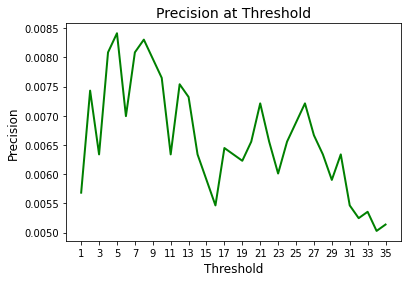

In [132]:
plt.plot(thresholds, precision_list, color='green', linewidth=2)

plt.title('Precision at Threshold', size=14)
plt.xlabel('Threshold', size=12)
plt.ylabel('Precision', size=12)

plt.xticks(range(1,36,2))

plt.show()